<a href="https://www.kaggle.com/code/seungeun5/titanic-com?scriptVersionId=92232981" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 프로젝트 개요
- 강의명 : 2022년 K-디지털 직업훈련(Training) 사업 - AI데이터플랫폼을 활용한 빅데이터 분석전문가 과정
- 교과목명 : 빅데이터 분석 및 시각화, AI개발 기초, 인공지능 프로그래밍
- 프로젝트 주제 : Spaceship Titanic 데이터를 활용한 탑승유무 분류모형 개발 
- 프로젝트 마감일 : 2022년 4월 12일 화요일
- 수강생명 : 오승은

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# 라이브러리 불러오기

- 프로젝트에 쓰일 라이브러리를 모두 불러온다

In [2]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.utils import resample

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

# 데이터 준비

- 훈련 데이터는 8693개, 테스트 데이터는 4277개이다
- 독립변수는 13개, 종속변수(타겟값)은 1개임을 확인했다

In [3]:
# Save to df
train = pd.read_csv('../input/spaceship-titanic/train.csv')
test = pd.read_csv('../input/spaceship-titanic/test.csv')

# Shape and preview
print('Train set shape:', train.shape)
print('Test set shape:', test.shape)
train.head()

Train set shape: (8693, 14)
Test set shape: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## 결측치 확인

In [4]:
print('TRAIN SET MISSING VALUES:')
print(train.isna().sum())
print('')
print('TEST SET MISSING VALUES:')
print(test.isna().sum())

TRAIN SET MISSING VALUES:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

TEST SET MISSING VALUES:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


- 거의 모든 데이터에 결측지 존재

## 중복 확인

- 중복된 row 값을 찾아주는 duplicated 메서드로 중복치를 확인해보자

In [5]:
print(f'Duplicates in train set: {train.duplicated().sum()}, ({np.round(100*train.duplicated().sum()/len(train),1)}%)')
print('')
print(f'Duplicates in test set: {test.duplicated().sum()}, ({np.round(100*test.duplicated().sum()/len(test),1)}%)')

Duplicates in train set: 0, (0.0%)

Duplicates in test set: 0, (0.0%)


- Cardinality of features (특성들의 중복 정도를 알아보자)
- 중복도가 ‘낮으면’ 카디널리티가 ‘높다’고 표현/중복도가 ‘높으면’ 카디널리티가 ‘낮다’고 표현

In [6]:
train.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

- 훈련 데이터들의 유형을 확인해본다

In [7]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

- train 데이터는 bool(1), float64(6), object(7)개로 구성되어 있다
- 머신러닝 모델 학습을 시키기 위해서 데이터들을 숫자형 타입으로 바꿀 필요가 있음 

# EDA

- 타겟(종속변수)인 transported 분포 확인

Text(0.5, 1.0, 'Target distribution')

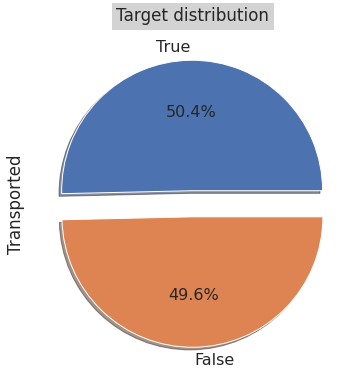

In [8]:
# Figure size
plt.figure(figsize=(6,6))

# Pie plot 
train['Transported'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Target distribution", backgroundcolor='lightgray',pad=20)


- 타겟 분포가 매우 고르므로 under sampling/ over sampling 하지 않아도 된다

- 연속형 변수들이 transported와 연관있는지 그래프를 그려 확인해보기

Text(0.5, 0, 'Age (years)')

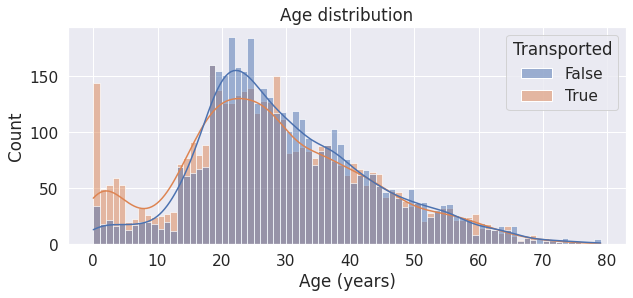

In [9]:
# Figure size
plt.figure(figsize=(10,4))

# Histogram
sns.histplot(data=train, x='Age', hue='Transported', binwidth=1, kde=True)

# Aesthetics
plt.title('Age distribution')
plt.xlabel('Age (years)')

- 0-18세는 tansported되는 경향이 높고, 18-25세는 transported 되지 않는 경향이 높고, 25세 이후로는 거의 비슷한 경향을 보인다
- child(0-18), adolescent(18-25), adult(25-)라는 새로운 특성을 만들자

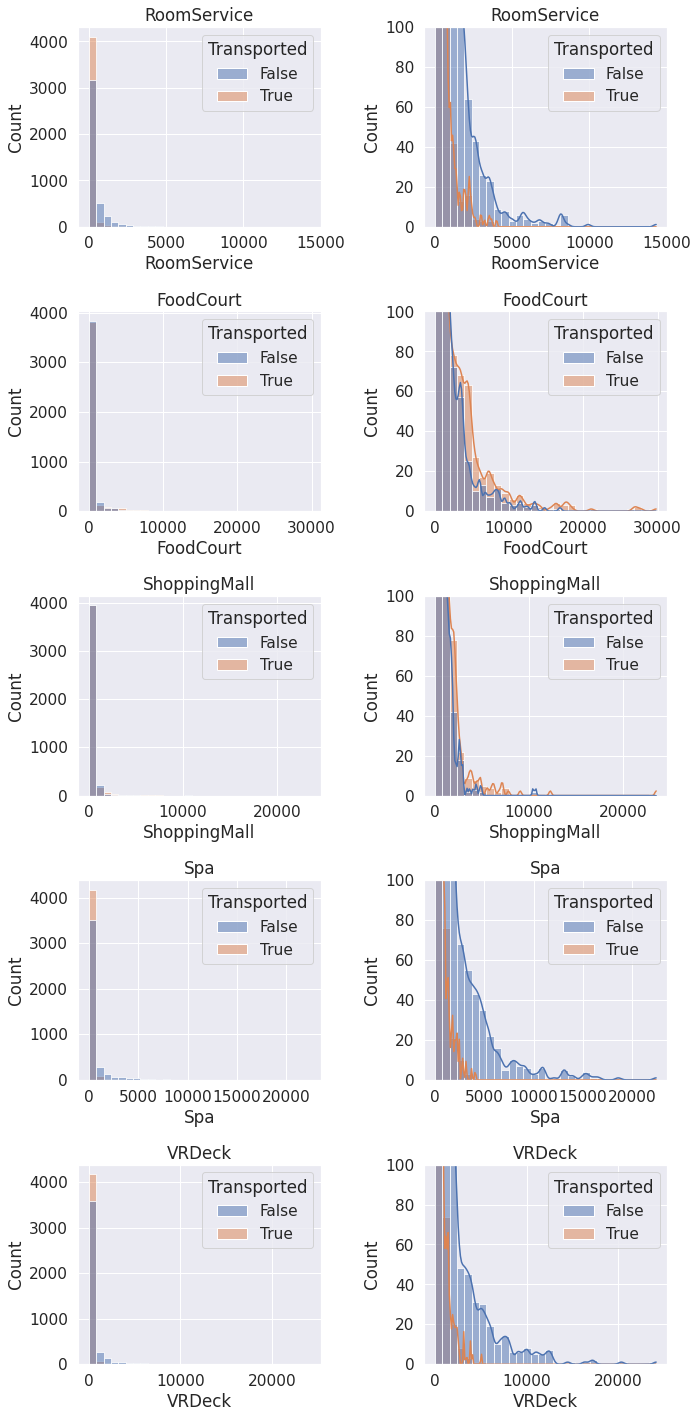

In [10]:
# Expenditure features
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Plot expenditure features
fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(exp_feats):
    # Left plot
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)
    
    # Right plot (truncated)
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

- transported된 사람들은 돈을 덜 쓴 경향이 있다
- outlier가 존재
- 소비 분포는 기하급수적으로 낮아진다
- 대부분의 사람들은 돈을 거의 쓰지 않았다
- insights : 
    + 5가지 시설에 대한 총 지출을 추적하는 새로운 변수 만들기
    + 지출을 했는지/ 안 했는지 binary 변수 만들기

- 범주형 변수들이 transported와 연관있는지 그래프를 그려 확인해보기

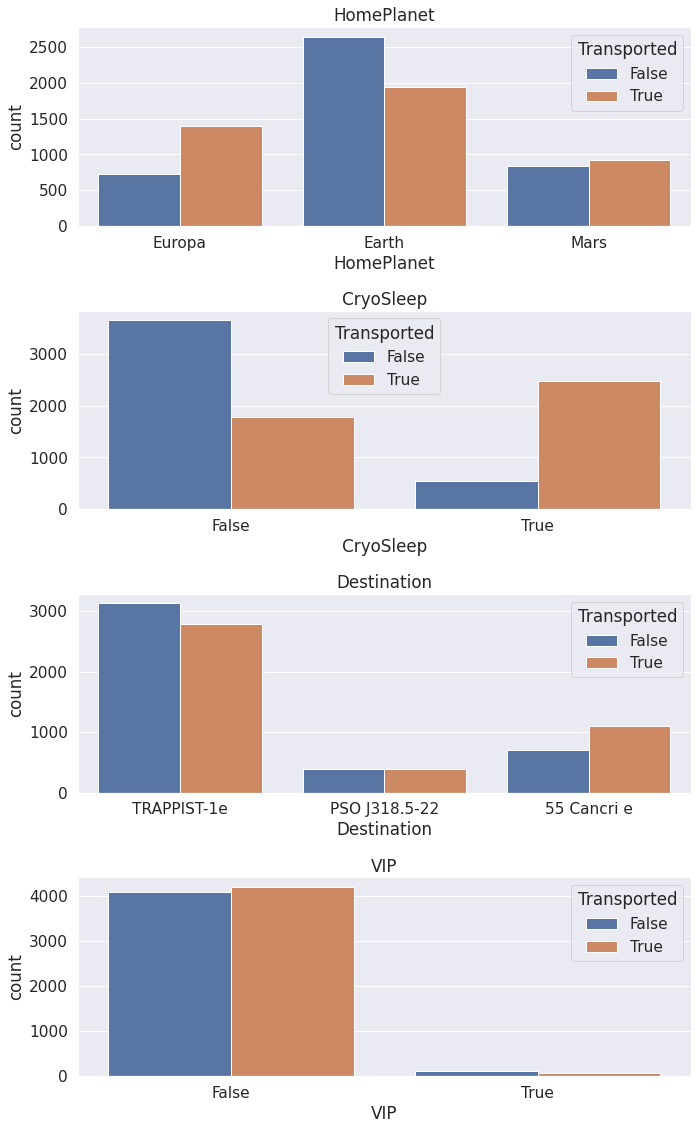

In [11]:
# Categorical features
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Plot categorical features
fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout() 
plt.show() 

- vip 특성은 transported의 차이가 없어서 유용한 특성이 아니라고 보여진다 -> overfitting을 방지하기 위해 이 특성을 삭제해야한다
- cryosleep은 transported의 차이가 나기 때문에 유용한 특성으로 보인다 

- 질적 변수들은 아직 시각화하지 못하므로 qual_feats으로 묶고 데이터 확인하기

In [12]:
# Qualitative features
qual_feats=['PassengerId', 'Cabin' ,'Name']

# Preview qualitative features
train[qual_feats].head()

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines


- PassengerId는 그룹_그룹 인원수 형태로 구성되어 있다
- Cabin은 갑판/번호/사이드 형태로 구성되어 있다
--> 그러므로
- PassengerId로부터 그룹/그룹 사이즈를 추출할 수 있다
- Cabin으로부터 갑판, 번호, 사이드를 추출할 수 있다
- Name으로부터 성을 추출할 수 있다

# 결측치 처리

Text(0.5, 1.0, 'Heatmap of missing values')

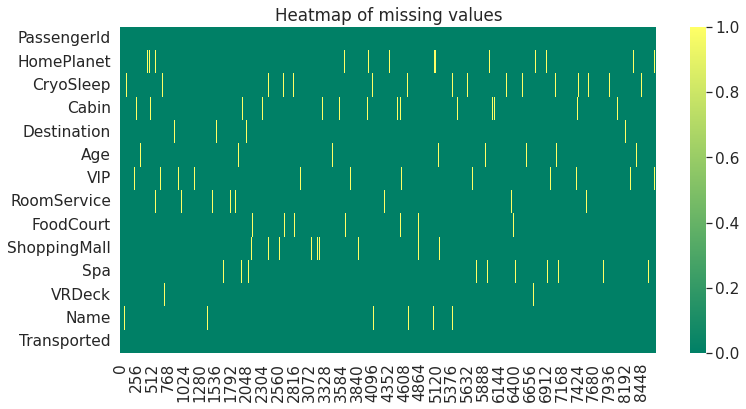

In [13]:
plt.figure(figsize=(12,6))
sns.heatmap(train.isna().T, cmap='summer')
plt.title('Heatmap of missing values')

- 결측치가 전체 데이터의 2%를 차지하고 있으며, 대부분 동시에 발생하지는 않는 것 같다
(결측치의 비중이 낮다)

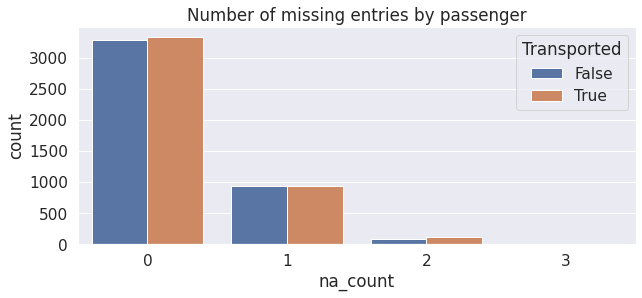

In [14]:
train['na_count']=train.isna().sum(axis=1)
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='na_count', hue='Transported')
plt.title('Number of missing entries by passenger')
train.drop('na_count', axis=1, inplace=True)

- 결측치들이 대부분 결과랑 분리되어 있으므로 이를 제거하기 보단 다른 적절한 값으로 채워주는 것이 합리적으로 보인다

- 연속형 데이터인 age의 결측치는 중앙값으로 채운다

In [15]:
# Impute median (for continuous data)
train['Age'].fillna(train['Age'].median(), inplace=True)
test['Age'].fillna(train['Age'].median(), inplace=True) # be careful of data leakage

- mode()를 사용해 가장 많이 등장하는 값을 알아본다

In [16]:
# Find mode of each categorical feature
train[['HomePlanet','CryoSleep','Destination','VIP']].mode()

,HomePlanet,CryoSleep,Destination,VIP
0,Earth,False,TRAPPIST-1e,False


- 각 데이터들의 결측치를 최빈값으로 채워준다

In [17]:
# Impute most frequent category (for categorical data)
train['HomePlanet'].fillna('Earth', inplace=True)
test['HomePlanet'].fillna('Earth', inplace=True)

train['CryoSleep'].fillna(False, inplace=True)
test['CryoSleep'].fillna(False, inplace=True)

train['Destination'].fillna('TRAPPIST-1e', inplace=True)
test['Destination'].fillna('TRAPPIST-1e', inplace=True)

train['VIP'].fillna(False, inplace=True)
test['VIP'].fillna(False, inplace=True)

# Impute 0's (mode) because we will create a categorical column from this later
for col in exp_feats:
    train.loc[train[col].isna(),col]=0
    test.loc[test[col].isna(),col]=0

- 질적 데이터인 Cabin과 Name 결측치 처리하기 (인위적으로 없는 값으로 채워준다)

In [18]:
# Impute outliers (for qualitative data)
train['Cabin'].fillna('Z/9999/Z', inplace=True)
test['Cabin'].fillna('Z/9999/Z', inplace=True)

train['Name'].fillna('No Name', inplace=True)
test['Name'].fillna('No Name', inplace=True)

# 특성 공학

- EDA를 단계를 참고하여 child(0-18), adolescent(18-25), adult(25-)라는 새로운 특성을 만들기

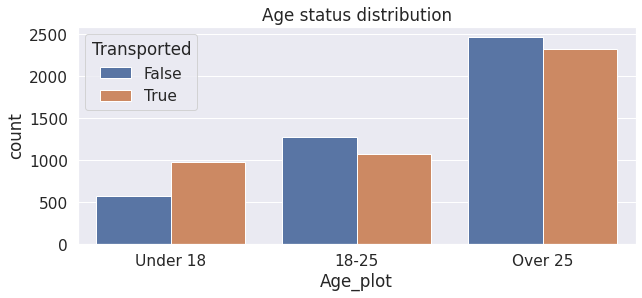

In [19]:
# New features - training set
train['Under_18']=(train['Age']<18).astype(int)
train['18_to_25']=((train['Age']>=18) & (train['Age']<=25)).astype(int)
train['Over_25']=(train['Age']>25).astype(int)

# New features - test set
test['Under_18']=(test['Age']<18).astype(int)
test['18_to_25']=((test['Age']>=18) & (test['Age']<=25)).astype(int)
test['Over_25']=(test['Age']>25).astype(int)

# Plot distribution of new features
train['Age_plot']=train['Under_18']+2*train['18_to_25']+3*train['Over_25']
plt.figure(figsize=(10,4))
g=sns.countplot(data=train, x='Age_plot', hue='Transported')
plt.title('Age status distribution')
g.set_xticklabels(['Under 18', '18-25', 'Over 25'])
train.drop('Age_plot', axis=1, inplace=True)

- 총지출을 계산하고 지출이 없는 승객들을 확인해보기

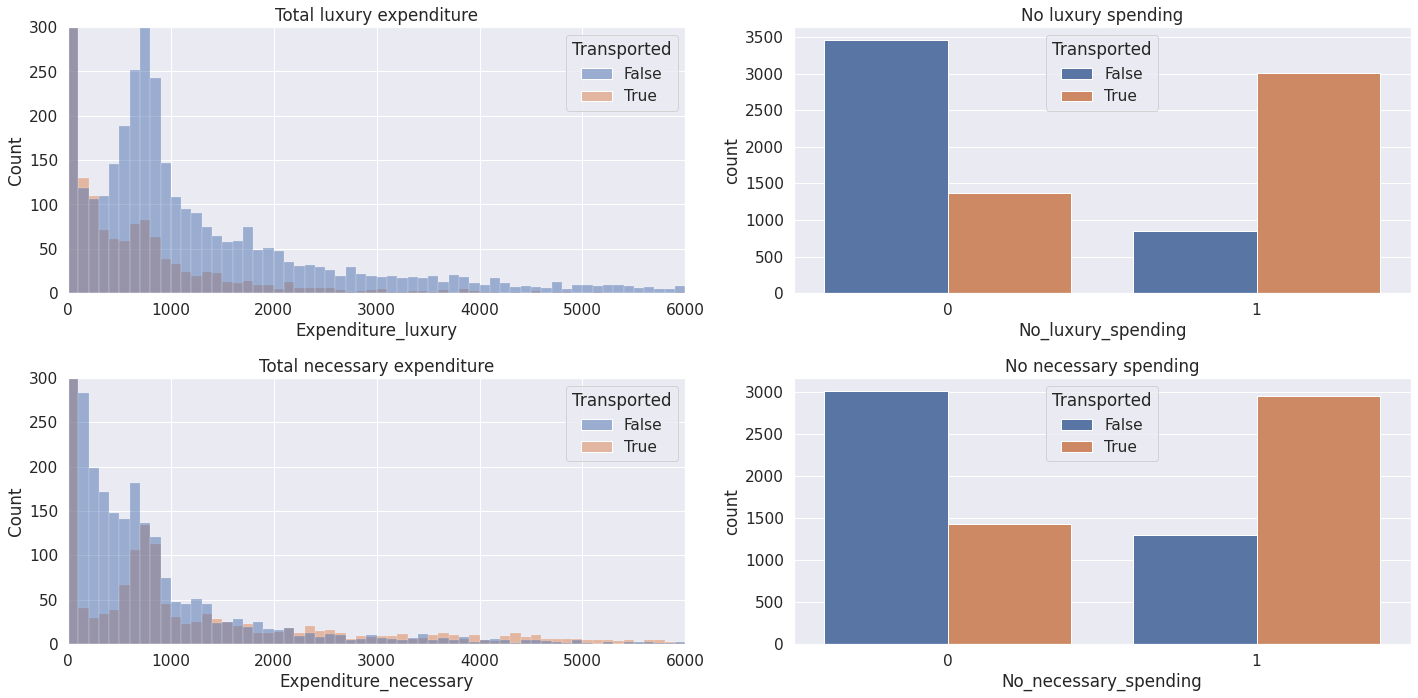

In [20]:
# New features - training set
train['Expenditure_luxury']=train['RoomService']+train['Spa']+train['VRDeck']
train['Expenditure_necessary']=train['FoodCourt']+train['ShoppingMall']
train['No_luxury_spending']=(train['Expenditure_luxury']==0).astype(int)
train['No_necessary_spending']=(train['Expenditure_necessary']==0).astype(int)

# New features - test set
test['Expenditure_luxury']=test['RoomService']+test['Spa']+test['VRDeck']
test['Expenditure_necessary']=test['FoodCourt']+test['ShoppingMall']
test['No_luxury_spending']=(test['Expenditure_luxury']==0).astype(int)
test['No_necessary_spending']=(test['Expenditure_necessary']==0).astype(int)

# Plot distribution of new features
fig=plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
sns.histplot(data=train, x='Expenditure_luxury', hue='Transported', binwidth=100)
plt.title('Total luxury expenditure')
plt.xlim([0,6000])
plt.ylim([0,300])

plt.subplot(2,2,2)
sns.countplot(data=train, x='No_luxury_spending', hue='Transported')
plt.title('No luxury spending')

plt.subplot(2,2,3)
sns.histplot(data=train, x='Expenditure_necessary', hue='Transported', binwidth=100)
plt.title('Total necessary expenditure')
plt.xlim([0,6000])
plt.ylim([0,300])

plt.subplot(2,2,4)
sns.countplot(data=train, x='No_necessary_spending', hue='Transported')
plt.title('No necessary spending')
fig.tight_layout()

- PassengerId로부터 group, group_size 추출하기

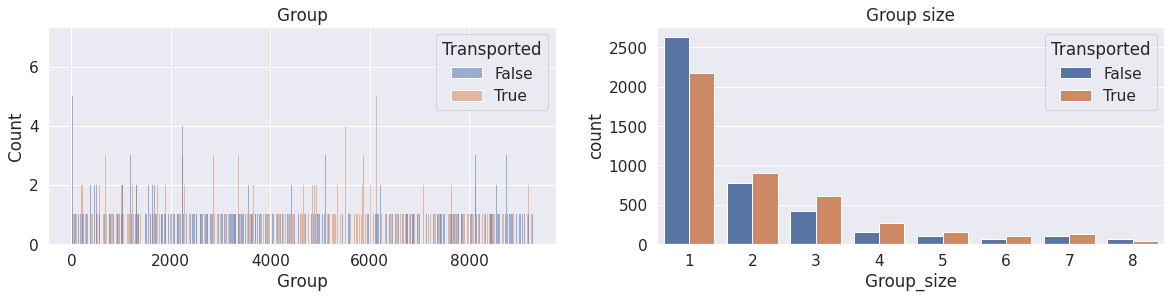

In [21]:
# New features - training set
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
train['Group_size']=train['Group'].map(lambda x: train['Group'].value_counts()[x])

# New features - test set
test['Group'] = test['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test['Group_size']=test['Group'].map(lambda x: test['Group'].value_counts()[x])

# Plot distribution of new features
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='Group', hue='Transported', binwidth=1)
plt.title('Group')

plt.subplot(1,2,2)
sns.countplot(data=train, x='Group_size', hue='Transported')
plt.title('Group size')
fig.tight_layout()

- group_size=1일 경우, solo라는 feature추가

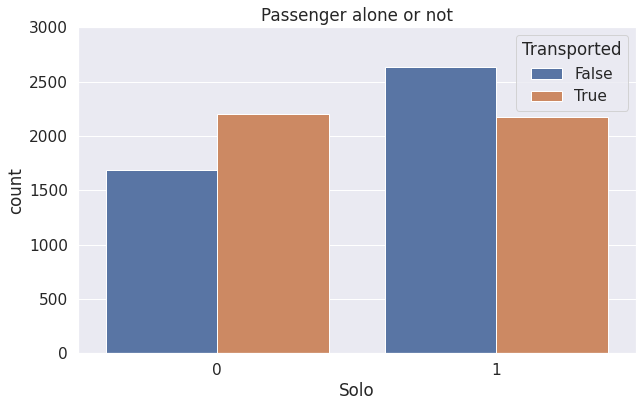

In [22]:
train['Solo'] = (train['Group_size']==1).astype(int)
test['Solo'] = (test['Group_size']==1).astype(int)

plt.figure(figsize=(10,6))
sns.countplot(data=train,x='Solo',hue='Transported')
plt.title('Passenger alone or not')
plt.ylim([0,3000])
plt.show()

- 혼자(솔로)인 승객들이 transported되는 경향이 적다

- Cabin으로 부터 deck,number,side 추출하기

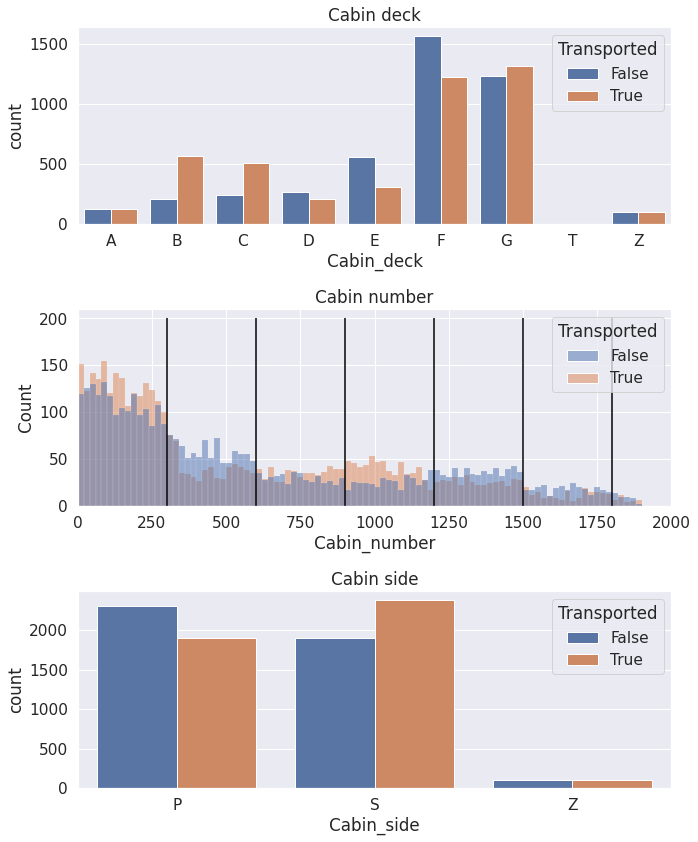

In [23]:
# New features - training set
train['Cabin_deck'] = train['Cabin'].apply(lambda x: x.split('/')[0])
train['Cabin_number'] = train['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
train['Cabin_side'] = train['Cabin'].apply(lambda x: x.split('/')[2])

# New features - test set
test['Cabin_deck'] = test['Cabin'].apply(lambda x: x.split('/')[0])
test['Cabin_number'] = test['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
test['Cabin_side'] = test['Cabin'].apply(lambda x: x.split('/')[2])

# Plot distribution of new features
fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=train, x='Cabin_deck', hue='Transported', order=['A','B','C','D','E','F','G','T','Z'])
plt.title('Cabin deck')

plt.subplot(3,1,2)
sns.histplot(data=train, x='Cabin_number', hue='Transported',binwidth=20)
plt.vlines(300, ymin=0, ymax=200, color='black')
plt.vlines(600, ymin=0, ymax=200, color='black')
plt.vlines(900, ymin=0, ymax=200, color='black')
plt.vlines(1200, ymin=0, ymax=200, color='black')
plt.vlines(1500, ymin=0, ymax=200, color='black')
plt.vlines(1800, ymin=0, ymax=200, color='black')
plt.title('Cabin number')
plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(data=train, x='Cabin_side', hue='Transported')
plt.title('Cabin side')
fig.tight_layout()

- Cabin_number은 300개씩 그룹화 되어있는 것 같다 -> 범주형으로 만들 수 있을듯
- The cabin deck 'T'는 5개 샘플밖에 존재하지않아서 아웃라이어 같다 


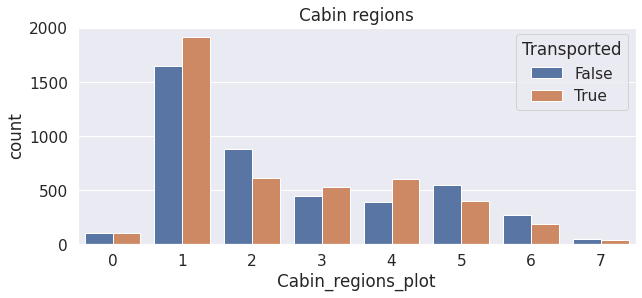

In [24]:
# New features - training set
train['Cabin_region1']=(train['Cabin_number']<300).astype(int)   # one-hot encoding
train['Cabin_region2']=((train['Cabin_number']>=300) & (train['Cabin_number']<600)).astype(int)
train['Cabin_region3']=((train['Cabin_number']>=600) & (train['Cabin_number']<900)).astype(int)
train['Cabin_region4']=((train['Cabin_number']>=900) & (train['Cabin_number']<1200)).astype(int)
train['Cabin_region5']=((train['Cabin_number']>=1200) & (train['Cabin_number']<1500)).astype(int)
train['Cabin_region6']=((train['Cabin_number']>=1500) & (train['Cabin_number']<1800)).astype(int)
train['Cabin_region7']=((train['Cabin_number']>=1800) & (train['Cabin_number']<2100)).astype(int)

# New features - test set
test['Cabin_region1']=(test['Cabin_number']<300).astype(int)   # one-hot encoding
test['Cabin_region2']=((test['Cabin_number']>=300) & (test['Cabin_number']<600)).astype(int)
test['Cabin_region3']=((test['Cabin_number']>=600) & (test['Cabin_number']<900)).astype(int)
test['Cabin_region4']=((test['Cabin_number']>=900) & (test['Cabin_number']<1200)).astype(int)
test['Cabin_region5']=((test['Cabin_number']>=1200) & (test['Cabin_number']<1500)).astype(int)
test['Cabin_region6']=((test['Cabin_number']>=1500) & (test['Cabin_number']<1800)).astype(int)
test['Cabin_region7']=((test['Cabin_number']>=1800) & (test['Cabin_number']<2100)).astype(int)

# Plot distribution of new features
plt.figure(figsize=(10,4))
train['Cabin_regions_plot']=(train['Cabin_region1']+2*train['Cabin_region2']+3*train['Cabin_region3']+4*train['Cabin_region4']+5*train['Cabin_region5']+6*train['Cabin_region6']+7*train['Cabin_region7']).astype(int)
sns.countplot(data=train, x='Cabin_regions_plot', hue='Transported')
plt.title('Cabin regions')
train.drop('Cabin_regions_plot', axis=1, inplace=True)

- Name에서 가족이름 추출

Text(0.5, 1.0, 'Family size')

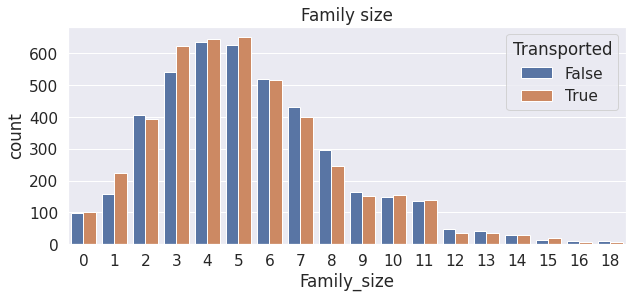

In [25]:
# New features - training set
# str.split().str[-1] : 문자열을 나눈 후 마지막열(-1)만 가져와라
train['Surname']=train['Name'].str.split().str[-1]
train['Family_size']=train['Surname'].map(lambda x: train['Surname'].value_counts()[x])

# New features - test set
test['Surname']=test['Name'].str.split().str[-1]
test['Family_size']=test['Surname'].map(lambda x: test['Surname'].value_counts()[x])

# Set outliers (no name) to have no family
train.loc[train['Family_size']==200,'Family_size']=0
test.loc[test['Family_size']==200,'Family_size']=0

# New feature distribution
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='Family_size', hue='Transported')
plt.title('Family size')

# 전처리

- 필요없는 특성들('PassengerId', 'Cabin', 'Name', 'Surname', 'Age', 'Group', 'Cabin_number') 을 drop 시켜준다

In [26]:
# Drop qualitative/redundant/high cardinality features
train.drop(['PassengerId', 'Cabin', 'Name', 'Surname', 'Age', 'Group', 'Cabin_number'], axis=1, inplace=True)
test.drop(['PassengerId', 'Cabin', 'Name', 'Surname', 'Age', 'Group', 'Cabin_number'], axis=1, inplace=True)

# Preview resulting training set
train.head()

,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,...,Cabin_deck,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Family_size
0,Europa,False,TRAPPIST-1e,False,0.0,0.0,0.0,0.0,0.0,False,...,B,P,1,0,0,0,0,0,0,1
1,Earth,False,TRAPPIST-1e,False,109.0,9.0,25.0,549.0,44.0,True,...,F,S,1,0,0,0,0,0,0,4
2,Europa,False,TRAPPIST-1e,True,43.0,3576.0,0.0,6715.0,49.0,False,...,A,S,1,0,0,0,0,0,0,6
3,Europa,False,TRAPPIST-1e,False,0.0,1283.0,371.0,3329.0,193.0,False,...,A,S,1,0,0,0,0,0,0,6
4,Earth,False,TRAPPIST-1e,False,303.0,70.0,151.0,565.0,2.0,True,...,F,S,1,0,0,0,0,0,0,6


- 원 데이터가 섞이는걸 방지하기 위해 복제해준다

In [27]:
y=train['Transported'].copy().astype(int)
X=train.drop('Transported', axis=1).copy()
X_test=test.copy()

- encoding & scaling
- Pipeline()
    + 서로 다른 매개변수를 설정하면서 교차 검증을 할 수 있는 단계들을 조합하기 위해 사용
    + data leakage 방지

In [28]:
# Indentify numerical and categorical columns
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

# Scale numerical data to have mean=0 and variance=1
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encode categorical data
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore',sparse=False))])

# Combine preprocessing
ct = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)],
        remainder='passthrough')

# Apply preprocessing
X = ct.fit_transform(X)
X_test = ct.transform(X_test)

# Print new shape
print('Training set shape:', X.shape)

Training set shape: (8693, 42)


## PCA

- 주성분 분석을 시행 (주성분 갯수는 3개로 지정)
- (8693, 3) 크기의 배열로 차원 축소
- PCA의 explained_variance_ratio_ 메서드를 사용하여 분산 비율(고유값/총 고유값)을 구한다
    + 설명된 분산은 특정 주성분을 사용하여 설명된 정보를 나타낸다
- 3차원 산점도를 사용하여 주성분들의 분포를 시각화한다

In [29]:
pca = PCA(n_components=3)
components = pca.fit_transform(X)
print(components.shape)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=y, size=0.1*np.ones(len(X)), opacity = 1,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    width=800, height=500
)
fig.show()

(8693, 3)


- 주성분이 원본데이터의 32.77%만큼만 설명하고 있다

- 적절한 주성분의 갯수 알아보기

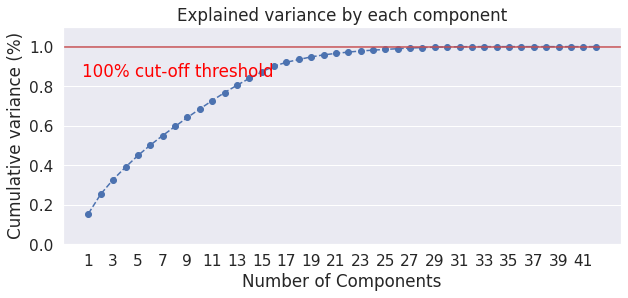

In [30]:
# Explained variance (how important each additional principal component is)
pca = PCA().fit(X)
fig, ax = plt.subplots(figsize=(10,4))
xi = np.arange(1, 1+X.shape[1], step=1)
yi = np.cumsum(pca.explained_variance_ratio_)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')

# Aesthetics
plt.ylim(0.0,1.1)
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 1+X.shape[1], step=2))
plt.ylabel('Cumulative variance (%)')
plt.title('Explained variance by each component')
plt.axhline(y=1, color='r', linestyle='-')
plt.text(0.5, 0.85, '100% cut-off threshold', color = 'red')
ax.grid(axis='x')

- 15개 이상의 주성분이 분산의 대부분을 표현하고 있다

- 검정을 위해 데이터 세트 분리한다

In [31]:
# Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(X,y,stratify=y,train_size=0.8,test_size=0.2,random_state=0)

# 모델 선택

In [32]:
# Classifiers
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=0),
    "KNN" : KNeighborsClassifier(),
    "RandomForest" : RandomForestClassifier(random_state=0),
    #"XGBoost" : XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss'), # XGBoost takes too long
    "LGBM" : LGBMClassifier(random_state=0),
    "CatBoost" : CatBoostClassifier(random_state=0, verbose=False),
}

# Grids for grid search
LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}



RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15]}




# Dictionary of all grids
grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
    "RandomForest" : RF_grid,
    "XGBoost" : boosted_grid,
    "LGBM" : boosted_grid,
    "CatBoost" : boosted_grid,
}

- 그리드 서치로 모델 훈련

In [33]:
i = 0
clf_best_params=classifiers.copy()
valid_scores=pd.DataFrame({'Classifier': classifiers.keys(), 'Validation accuracy': np.zeros(len(classifiers)), 'Training time': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)
    
    # train and score
    clf.fit(X_train,y_train)
    valid_scores.iloc[i,1]=clf.score(X_valid, y_valid)
    
    # save trained model
    clf_best_params[key]=clf.best_params_
    
    # print iteration and training time
    stop = time.time()
    valid_scores.iloc[i:2] = np.round((start-stop)/60,2)
    
    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,2])
    print('')
    i+=1
    

Model: LogisticRegression
Training time (mins): -0.08

Model: KNN
Training time (mins): -0.09

Model: RandomForest
Training time (mins): 0.0

Model: LGBM
Training time (mins): 0.0

Model: CatBoost
Training time (mins): 0.0



In [34]:
# Show results
valid_scores

,Classifier,Validation accuracy,Training time
0,-0.08,-0.080000,-0.08
1,-0.09,-0.090000,-0.09
2,RandomForest,0.799310,0.00
3,LGBM,0.789534,0.00
4,CatBoost,0.799885,0.00


- 이 결과를 보니 모델링 마지막 단계에서 RandomForest, LGBM , CatBoost를 시행하는 것이 좋아보인다

In [35]:
# Show best parameters from grid search
clf_best_params

{'LogisticRegression': {'C': 1.25, 'max_iter': 100, 'penalty': 'l2'},
 'KNN': {'n_neighbors': 9, 'p': 1},
 'RandomForest': {'max_depth': 12, 'n_estimators': 100},
 'LGBM': {'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 50},
 'CatBoost': {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 150}}

# 모델링

- 전체 훈련세트에 대해 가장 좋은 모델을 훈련시킨다
- 마지막으로 교차 검증 전체 교육 세트에 대해 최고의 모델을 교육및 앙상블 예측을 함께 사용한다

In [36]:
# Classifiers
best_classifiers = {
    "RandomForest" : RandomForestClassifier(**clf_best_params["RandomForest"], random_state=0),
    "LGBM" : LGBMClassifier(**clf_best_params["LGBM"], random_state=0),
    "CatBoost" : CatBoostClassifier(**clf_best_params["CatBoost"], verbose=False, random_state=0),
}

- 교차검증과 앙상블 예측 시행하기

In [37]:
# Number of folds in cross validation
FOLDS=10

preds=np.zeros(len(X_test))
for key, classifier in best_classifiers.items():
    start = time.time()
    
    # 5-fold cross validation
    cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=0)
    
    score=0
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        # Get training and validation sets
        X_train, X_valid = X[train_idx], X[val_idx]
        y_train, y_valid = y[train_idx], y[val_idx]

        # Train model
        clf = classifier
        clf.fit(X_train, y_train)

        # Make predictions and measure accuracy
        preds += clf.predict_proba(X_test)[:,1]
        score += clf.score(X_valid, y_valid)

    # Average accuracy    
    score=score/FOLDS
    
    # Stop timer
    stop = time.time()

    # Print accuracy and time
    print('Model:', key)
    print('Average validation accuracy:', np.round(100*score,2))
    print('Training time (mins):', np.round((stop - start)/60,2))
    print('')
    
# Ensemble predictions
preds=preds/(FOLDS*len(best_classifiers))

Model: RandomForest
Average validation accuracy: 80.73
Training time (mins): 0.14

Model: LGBM
Average validation accuracy: 80.78
Training time (mins): 0.02

Model: CatBoost
Average validation accuracy: 80.93
Training time (mins): 0.23



- 혼동행렬 (Confusion Matrix) 
    + 주로 분류문제에서 모델의 성능을 평가할 때 혼동행렬 형태를 사용한다
    + 4가지 개념 -> 앞이 T면 예측이 맞았음/ F이면 예측이 틀렸음을 의미 , 뒤가 P면 예측을 양성으로 했음/ N이면 예측을 음성으로 했음을 의미
        + TP/TN/FP/FN
        + TP는 true positive로 양성(1)으로 예측했는데 양성(1)일 경우를 말한다
        + TF는 true negative로 음성(0)으로 예측했는데 음성(0)일 경우를 말한다
        + FP는 false positive로 양성(1)으로 예측했는데 음성(0)일 경우를 말한다
        + FN는 false negative로 음성(0)으로 예측했는데 양성(1)일 경우를 말한다  
    + 평가지표 5가지
        + 정확도 = 전체에서 TP와 TF가 차지하는 비율 = (TP+TF) / (TP+TF+FP+FN)
        + 정밀도 = 양성으로 예측한 경우 중에서 실제 양성인 비율 = TP / (TP+FP)
        + 재현율 = 실제 양성 중에 제대로 예측한 비율 = TP / (TP+FN)
        + 특이도 = 실제 음성 중에 제대로 예측한 비율 = TN / (TN+FP)
        + F1 score = 정밀도와 재현율의 조화평균 = (2*정밀도*재현율) / (정밀도+재현율)
        
          
참고자료 : https://taeguu.tistory.com/32

# 제출

In [38]:
# Round predictions to nearest integer
preds=np.round(preds).astype(int)

Text(0.5, 1.0, 'Prediction distribution')

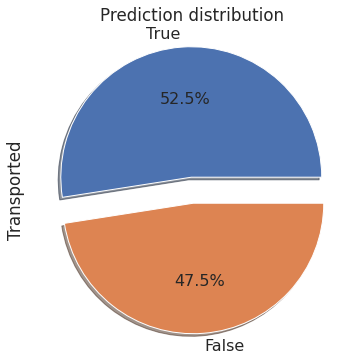

In [39]:
# Sample submission (to get right format)
sub=pd.read_csv('../input/spaceship-titanic/sample_submission.csv')

# Add predictions
sub['Transported']=preds

# Replace 0 to False and 1 to True
sub=sub.replace({0:False,1:True})

# Prediction distribution
plt.figure(figsize=(6,6))
sub['Transported'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Prediction distribution")

In [40]:
# Output to csv
sub.to_csv('submission.csv', index=False)

# 출처
SAMUEL CORTINHAS /Spaceship Titanic: A complete guide/ https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide#Libraries